### 다중 분류 <hr>
- 데이터셋 : scikit-learn Fashion MNIST
- 데이터수 : 학습용 60000, 테스틍용 10000
- 피쳐갯수 : 28 X 28 흑백 이미지로 784
- 타겟갯수 : 티셔츠/상의, 바지, 풀오버, 드레스, 코트, 샌들, 셔츠, 운동화, 가방, 발목 부츠 등 10가지

[1] 모듈 로딩 및 데이터 준비 <hr>

In [317]:
### ===> 모듈 로딩
from sklearn.datasets import fetch_openml 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
import torch.nn.functional as F 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim 
import torchmetrics.functional as metrics
import numpy as np

In [318]:
### ===> 데이터 로딩 
db_name = 'Fashion-MNIST'

# as_frame=False : ndarray 형식으로 반환
fashion_data = fetch_openml(name=db_name, parser='auto', as_frame=False)

In [319]:
### ===> 데이터 확인
print(f'data   => {fashion_data["data"].dtype}, {fashion_data["data"].shape}')
print(f'target => {fashion_data["target"].dtype}, {fashion_data["target"].shape}')
print(f'feature_names => {fashion_data["feature_names"]}\ntarget_names => {fashion_data["target_names"]}')
print(f'categories => {fashion_data["categories"]}')

data   => int64, (70000, 784)
target => object, (70000,)
feature_names => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85',

[2] 데이터 전처리 - 피쳐와 타겟 분리, 정규화 <hr>

In [320]:
### ===> 피쳐와 타겟 분리
# sklearn dataset 에서 이미 처리 해둠
feature=fashion_data['data']
target=fashion_data['target']

print(f'feature => {type(feature)}, {feature.shape}')
print(f'feature raw data =>\n{feature[:1]}\n')

print(f'target  => {type(target)},{target.shape}')
print(f'target raw data  => {target[:1]}')

feature => <class 'numpy.ndarray'>, (70000, 784)
feature raw data =>
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0
    0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0
   36 136 127  62  54   0   0   0   1   3   4   0   0   3   0   0   0   0
    0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0
    0   0   0  12  10   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15   0   0
    0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163
  127 121 122 146 141  88 172  66   0   0  

In [321]:
### ===> 정규화 : 피쳐
# 이미지 데이터 값 0 ~ 255b
norm_feature =feature/255.

print(f'norm_feature =>\n{norm_feature[:2]}')
print(f'norm_feature min => {norm_feature.min()}   max => { norm_feature.max()}')

norm_feature =>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
norm_feature min => 0.0   max => 1.0


In [322]:
### ===> 정규화 : 타겟
# # 타겟 분류 클래스 : '0' ~ '9'  ==> 0 ~ 9 정수 변환
norm_target=target.astype(int)
print(f'norm_target : {norm_target.dtype} {np.unique(norm_target).size}개')


norm_target : int32 10개


In [323]:
print(f'norm_target => {norm_target.shape}, {norm_target.ndim}D\n{norm_target[:5]}')

norm_target => (70000,), 1D
[9 0 0 3 0]


[3] 학습 데이터 셋 준비 - 훈련용, 검증용, 테스트용 데이터 셋 <hr>

- [3-1] 사용자 정의 데이터 셋 및 전체 데이터셋 준비

In [324]:
### 사용자정의 DataSet 클래스 
# - 데이터의 Tensor 변환 
class DLDataset(Dataset):
    
    # 초기화 함수 콜백함수(callback funcaion)
    def __init__(self, x_data, y_data):
        super().__init__()
        # ndarray ==> tensor
        self.feature=torch.FloatTensor(x_data)
        self.target=torch.LongTensor(y_data)
        
        
    # 데이터셋의 갯수 체크 함수 콜백함수(callback funcaion)
    def __len__(self):
        return self.target.shape[0]
    
    
    # 특정 인덱스 데이터+라벨 반환 콜백함수(callback funcaion)
    def __getitem__(self, index):
        return self.feature[index], self.target[index]

In [325]:
### 전체 데이터셋 생성
##  DataSet 생성
all_dataset = DLDataset(norm_feature, norm_target)

print(f'[all dataset] feature : {all_dataset.feature.shape},   target : {all_dataset.target.shape}')

[all dataset] feature : torch.Size([70000, 784]),   target : torch.Size([70000])


- [3-2] 학습용, 검증용, 테스트용 데이터셋 분리 

In [326]:
# 랜덤 고정 설정
seed_gen=torch.Generator().manual_seed(42)

TR_SIZE, VA_SIZE, TE_SIZE = 0.7, 0.1, 0.2

trainDS, validDS, testDS = random_split(all_dataset, 
                                  [TR_SIZE, VA_SIZE, TE_SIZE], 
                                  generator=seed_gen)

print(f"Train dataset length    : {len(trainDS)}개")
print(f"Validation dataset      : {len(validDS)}개")
print(f"Test dataset            : {len(testDS)}개")

Train dataset length    : 49000개
Validation dataset      : 7000개
Test dataset            : 14000개


[4] 데이터 로더 생성 <hr>

In [327]:
BATCH_SIZE = 50

TRAIN_DL = DataLoader(trainDS, batch_size=BATCH_SIZE)
VALID_DL = DataLoader(validDS, batch_size=BATCH_SIZE)
TEST_DL = DataLoader(testDS,   batch_size=BATCH_SIZE)

[5] 모델 준비 : 입력층 입력 수, 출력층 출력 수 <hr>

In [328]:
### ===> 다중 분류 모델
### ===> 입력층 피쳐 수  : 28 * 28
### ===> 출력층 피쳐 수  : 10 (0 ~ 9)
class MNISTModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layer1=nn.Linear(in_dim, 200)
        self.layer2=nn.Linear(200, 100)
        self.layer3=nn.Linear(100, 50)
        self.layer4=nn.Linear(50, out_dim)
        self.relu=nn.ReLU()
        
    def forward(self, x):
        y=self.layer1(x)
        y=self.relu(y)
        y=self.layer2(y)
        y=self.relu(y)
        y=self.layer3(y)
        y=self.relu(y)
        y=self.layer4(y)
        return y
        

In [329]:
class NOAHModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.first=in_dim
        self.last=out_dim
        self.relu=nn.Tanh()
        self.layer=nn.ModuleList() # 빈 리스트 생성
        
        while True:
            self.layer.append(nn.Linear(self.first, int(np.sqrt(self.first*self.last))))
            self.layer.append(self.relu)
            if int(np.sqrt(self.first*self.last)) <= self.last :
                break
            self.first=int(np.sqrt(self.first*self.last))
        
        
    def forward(self, x):
        for i in self.layer:
            x=i(x)
        
        return x
# nn.ModuleList() : 여러개의 nn.Module을 하나로 묶어주는 역할
# nn.ModuleList([nn.Linear(10,10) for i in range(n_hidden)])

In [330]:
NOAHModel(28*28, 10).modules

<bound method Module.modules of NOAHModel(
  (relu): Tanh()
  (layer): ModuleList(
    (0): Linear(in_features=784, out_features=88, bias=True)
    (1): Tanh()
    (2): Linear(in_features=88, out_features=29, bias=True)
    (3): Tanh()
    (4): Linear(in_features=29, out_features=17, bias=True)
    (5): Tanh()
    (6): Linear(in_features=17, out_features=13, bias=True)
    (7): Tanh()
    (8): Linear(in_features=13, out_features=11, bias=True)
    (9): Tanh()
    (10): Linear(in_features=11, out_features=10, bias=True)
    (11): Tanh()
  )
)>

- [6-1] 학습 진행 준비 :  모델, 최적화, 학습횟수 

In [331]:
# 실행 디바이스 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 입출력 피쳐
IN_DIM , OUT_DIM = norm_feature.shape[1], np.unique(norm_target).size

# 모델 인스턴스 
MODEL = NOAHModel(IN_DIM,OUT_DIM).to(DEVICE)
#MNISTModel(IN_DIM, OUT_DIM).to(DEVICE)

# 최적화 인스턴스 생성
OPTIMIZER = optim.SGD(MODEL.parameters())

#  손실 함수
LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)

# 학습 횟수 설정
EPOCHS=30

# 분류 갯수 
CLASSES = 10

[6] 학습 관련 함수 정의 <hr>

In [332]:
### ===> 학습 진행함수 
def training(epoch):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    MODEL.train()
    
    # 배치크기 만큼 학습 진행 및 저장
    train_report=[[], [], []]
    for idx, (feature, target)  in enumerate(TRAIN_DL):
        # 배치크기만큼의 학습 데이터 준비
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_traget = MODEL(feature)
        
        # 손실계산
        loss = LOSS_FN(pre_traget, target)
        train_report[0].append(loss)
        
        # 성능 평가
        acc = metrics.accuracy(pre_traget, target, task='multiclass', num_classes=CLASSES)
        train_report[1].append(acc)
        
        f1 = metrics.f1_score(pre_traget, target, task='multiclass', num_classes=CLASSES)
        train_report[2].append(f1)
        
        # W,b업데이트
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        
        if not idx%50: print('.', end='')
    
    
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(train_report[0])/BATCH_SIZE).item()
    acc_score = (sum(train_report[1])/BATCH_SIZE).item()
    f1_score = (sum(train_report[2])/BATCH_SIZE).item() 
    print(f'\n[{epoch} Train ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}')
    
    return loss_score, acc_score, f1_score

In [333]:
### ===> 검증 및 테스트 진행함수 
def testing(epoch, kind='valid'):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    MODEL.eval()
        
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장
        test_report=[[], [], []]
        for idx, (feature, target)  in enumerate(VALID_DL if kind == 'valid' else TEST_DL):
            # 배치크기만큼의 학습 데이터 준비
            feature, target = feature.to(DEVICE), target.to(DEVICE)

            # 학습
            pre_traget = MODEL(feature)

            # 손실계산
            loss = LOSS_FN(pre_traget, target)
            test_report[0].append(loss)
            
            # 성능 평가 
            acc = metrics.accuracy(pre_traget, target, task='multiclass', num_classes=CLASSES)
            test_report[1].append(acc)
            
            f1 = metrics.f1_score(pre_traget, target, task='multiclass', num_classes=CLASSES)
            test_report[2].append(f1)
            
            #if not idx%50: print('.', end='')

    testing_type = 'Valid' if kind == 'valid' else 'Test'
        
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(test_report[0])/BATCH_SIZE).item()
    acc_score = (sum(test_report[1])/BATCH_SIZE).item()
    f1_score = (sum(test_report[2])/BATCH_SIZE).item() 
    print(f'[{epoch} {testing_type} ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}\n')
    
    return loss_score, acc_score, f1_score

[7] 학습 : 학습 진행 준비, 학습 진행 <hr>

- [7-2] 학습 진행

In [334]:
# 학습 중 모델 저장 관련 변수
dir = '../data/model/'
filename=dir+'best_model.pth'
import os

if not os.path.exists(dir):
    os.makedirs(dir) # 다 만들어줌
    

In [335]:
# 학습 및 검증 데이터별 성능지표 값
train_ = {'loss':[], 'acc':[], 'f1':[]}
val_ = {'loss':[], 'acc':[], 'f1':[]}

# 모델 저장 관련 변수
pre_va_score = 100

# 학습 진행 
for epo in range(EPOCHS):
    print(f"[Epoch {epo+1}/{EPOCHS}] ", end='')
    tr_score=training(epo)
    va_score=testing(epo)
    
    # 검증 데이터 기준 학습된 모델 저장 => Loss가 이전보다 작아진 경우에 저장/Acc또는 F1이면 이전보다 큰 경우 저장 
    if pre_va_score > va_score[0]: # 1) Loss 기준
        pre_va_score = va_score[0]
        torch.save(MODEL, filename)
        print(f"Model saved at {filename}")
    
    for idx, key in enumerate(train_):
        train_[key].append(tr_score[idx])
        val_[key].append(va_score[idx])

print("Done!")

[Epoch 1/30] ..

..................
[0 Train ] Loss ==> 45.368 Acc ==> 1.971 F1 ==> 1.971
[0 Valid ] Loss ==> 6.471 Acc ==> 0.281 F1 ==> 0.281

Model saved at ../data/model/best_model.pth
[Epoch 2/30] ....................
[1 Train ] Loss ==> 45.201 Acc ==> 1.971 F1 ==> 1.971
[1 Valid ] Loss ==> 6.446 Acc ==> 0.281 F1 ==> 0.281

Model saved at ../data/model/best_model.pth
[Epoch 3/30] ....................
[2 Train ] Loss ==> 45.015 Acc ==> 1.971 F1 ==> 1.971
[2 Valid ] Loss ==> 6.416 Acc ==> 0.281 F1 ==> 0.281

Model saved at ../data/model/best_model.pth
[Epoch 4/30] ....................
[3 Train ] Loss ==> 44.762 Acc ==> 1.971 F1 ==> 1.971
[3 Valid ] Loss ==> 6.370 Acc ==> 0.282 F1 ==> 0.282

Model saved at ../data/model/best_model.pth
[Epoch 5/30] ....................
[4 Train ] Loss ==> 44.341 Acc ==> 2.000 F1 ==> 2.000
[4 Valid ] Loss ==> 6.288 Acc ==> 0.293 F1 ==> 0.293

Model saved at ../data/model/best_model.pth
[Epoch 6/30] ....................
[5 Train ] Loss ==> 43.528 Acc ==> 2.569 F1 ==> 2.5

- [7-3] 학습 후 평가 : Loss, Acc, F1 <hr>

In [336]:
data=[]
for idx, key in enumerate(train_):
    print(f'{key} ', train_[key])
    data.append(train_[key])
    
data2=[]
for idx, key in enumerate(val_):
    print(f'{key} ', val_[key])
    data2.append(val_[key])

loss  [45.367984771728516, 45.20134353637695, 45.014732360839844, 44.76213836669922, 44.34104537963867, 43.527618408203125, 42.078914642333984, 40.289398193359375, 38.770328521728516, 37.692256927490234, 36.963897705078125, 36.47480010986328, 36.14155197143555, 35.907257080078125, 35.73627853393555, 35.606651306152344, 35.5050048828125, 35.42286682128906, 35.354679107666016, 35.29682540893555, 35.24677276611328, 35.20262908935547, 35.16301345825195, 35.12685012817383, 35.09321212768555, 35.06138229370117, 35.03061294555664, 35.000160217285156, 34.96916580200195, 34.936561584472656]
acc  [1.9708033800125122, 1.9708033800125122, 1.9708033800125122, 1.9708033800125122, 2.000403642654419, 2.5692052841186523, 4.370404243469238, 4.741199016571045, 4.339598178863525, 4.041996479034424, 4.0815958976745605, 4.1207966804504395, 4.1487956047058105, 4.193198204040527, 4.235995292663574, 4.291595935821533, 4.379595756530762, 4.520400047302246, 4.7712016105651855, 5.185204029083252, 5.68559932708740

[6] 테스트 <hr>

In [337]:
np.array(data).T[:,0]

array([45.36798477, 45.20134354, 45.01473236, 44.76213837, 44.34104538,
       43.52761841, 42.07891464, 40.28939819, 38.77032852, 37.69225693,
       36.96389771, 36.47480011, 36.14155197, 35.90725708, 35.73627853,
       35.60665131, 35.50500488, 35.42286682, 35.35467911, 35.29682541,
       35.24677277, 35.20262909, 35.16301346, 35.12685013, 35.09321213,
       35.06138229, 35.03061295, 35.00016022, 34.9691658 , 34.93656158])

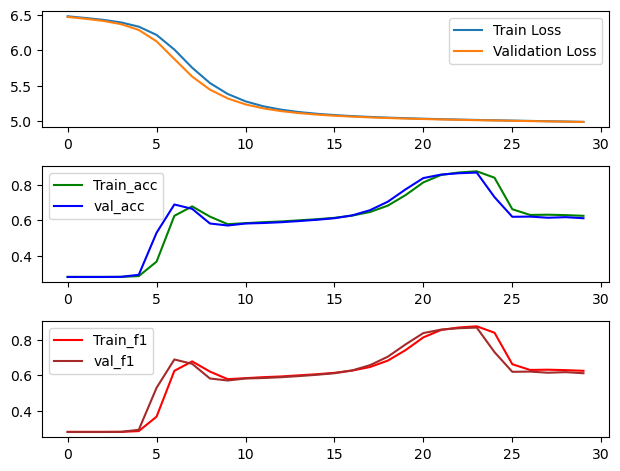

In [342]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = plt.subplot2grid((3,1), (0,0))
ax2 = plt.subplot2grid((3,1), (1,0))
ax3 = plt.subplot2grid((3,1), (2,0))


ax1.plot(np.array(data).T[:,0]/7, label='Train Loss')
ax1.plot(np.array(data2).T[:,0], label='Validation Loss')
ax1.legend()
ax2.plot(np.array(data).T[:,1]/7, label='Train_acc', color="green")
ax2.plot(np.array(data2).T[:,1], label='val_acc', color="blue")
ax2.legend()
ax3.plot(np.array(data).T[:,2]/7, label='Train_f1', color="red")
ax3.plot(np.array(data2).T[:,2], label='val_f1', color="brown")
plt.tight_layout()
plt.legend()
plt.show()

In [339]:
# 모델 테스트
MODEL = torch.load(filename)# 모델을 갖고와서

In [340]:
MODEL.state_dict() # 매개변수를 부를 수 있다 

OrderedDict([('layer.0.weight',
              tensor([[ 0.0291,  0.0060,  0.0275,  ..., -0.0211, -0.0333, -0.0238],
                      [ 0.0310, -0.0162, -0.0007,  ...,  0.0027,  0.0135, -0.0228],
                      [-0.0058, -0.0153,  0.0127,  ...,  0.0102, -0.0093, -0.0083],
                      ...,
                      [-0.0077, -0.0289,  0.0144,  ..., -0.0097, -0.0254,  0.0100],
                      [ 0.0036,  0.0140, -0.0202,  ...,  0.0035, -0.0344, -0.0225],
                      [ 0.0235,  0.0278,  0.0027,  ..., -0.0273,  0.0002,  0.0281]])),
             ('layer.0.bias',
              tensor([ 0.0198, -0.0305,  0.0077, -0.0238,  0.0226,  0.0123,  0.0199, -0.0014,
                      -0.0088,  0.0251,  0.0094, -0.0239, -0.0343,  0.0117, -0.0111,  0.0075,
                       0.0029, -0.0194, -0.0120, -0.0220,  0.0305, -0.0052, -0.0107, -0.0190,
                      -0.0329, -0.0099, -0.0235,  0.0087,  0.0194,  0.0124,  0.0061, -0.0254,
                      -0.021